In [1]:
import sys
sys.path.append('/home/hsher/scSecretome')
from scSecretome.sc import *

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.3 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


# A comprehensive single cell transcriptional landscape of human hematopoietic progenitors, Nature 2019

- There are two sets of single cell data from two human.
- Each types of cell is sorted by FACs and operated in parallel --> batch effect?

In [2]:
# all the data
from os import listdir
file_list = listdir('/data2/hsher/nature2019_sc/raw_counts/')
# the paper contain data from two patients
sample_two = [s for s in file_list if 'Lin' in s]
sample_one = [s for s in file_list if 'Lin' not in s]

In [3]:
sample_one # only CD45+ cells

['GSM3305359_HSC.raw_counts.tsv',
 'GSM3305360_MPP.raw_counts.tsv',
 'GSM3305363_MEP.raw_counts.tsv',
 'GSM3305364_CMP.raw_counts.tsv',
 'GSM3305365_GMP.raw_counts.tsv',
 'GSM3305362_PreBNK.raw_counts.tsv',
 'GSM3305361_MLP.raw_counts.tsv']

In [4]:
sample_two # cells more than CD45

['GSM3305369_LinNegCD34NegCD164low.raw_counts.tsv',
 'GSM3305367_LinNegCD34NegCD164high.raw_counts.tsv',
 'GSM3305368_LinNegCD34lowCD164high.raw_counts.tsv',
 'GSM3305366_LinNegCD34PosCD164Pos.raw_counts.tsv']

## In this paper, they have different transcript per cell threshold for each kind of cell.
As you can see in the benchmarking matrix, the quality of data is quite different.
Also, in some paper they mention different cell types should have different threshold. For example neutrophils inheritantly has less RNAs compared to other kinds of cell.

## Benchmarking matrix

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Library
GSM3305359_HSC.raw_counts.tsv


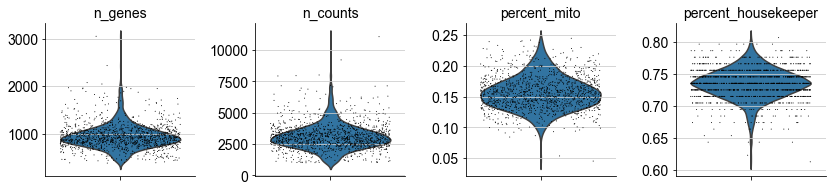

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Library
GSM3305360_MPP.raw_counts.tsv


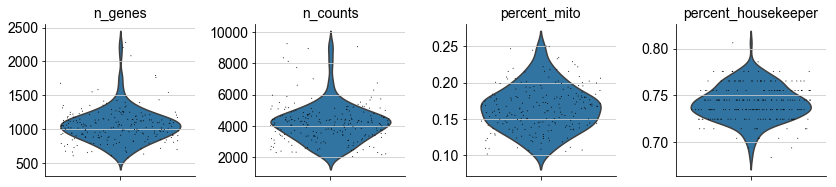

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Library
GSM3305363_MEP.raw_counts.tsv


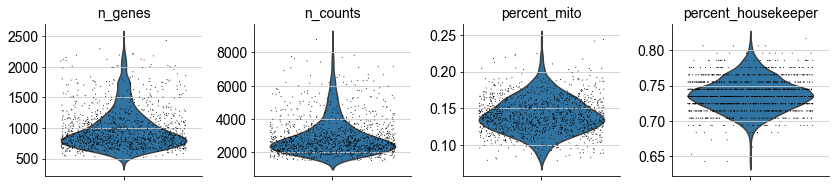

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Library
GSM3305364_CMP.raw_counts.tsv


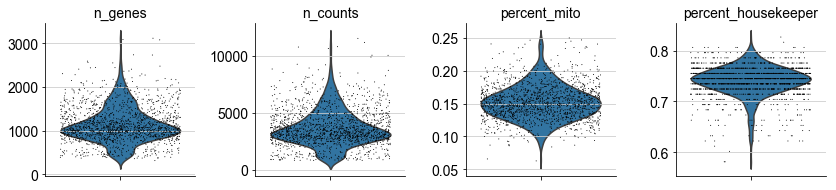

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Library
GSM3305365_GMP.raw_counts.tsv


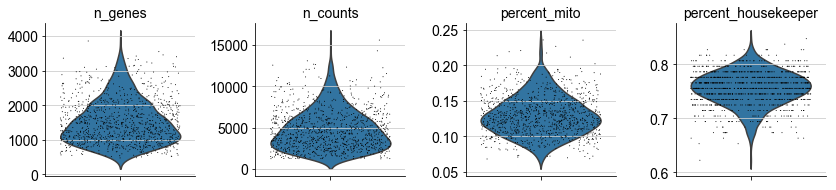

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Library
GSM3305362_PreBNK.raw_counts.tsv


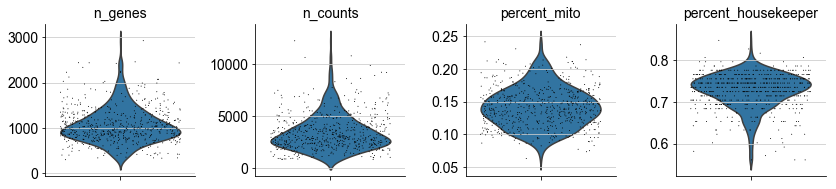

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Library
GSM3305361_MLP.raw_counts.tsv


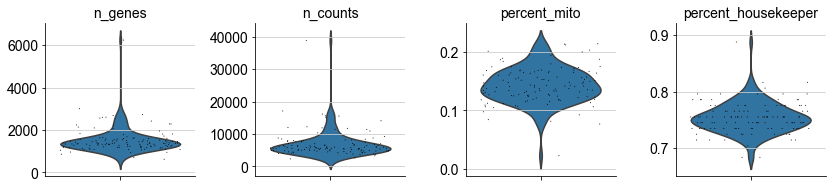

In [5]:
for s in sample_one:
    # run benchmarking
    d = read_raw_counts('/data2/hsher/nature2019_sc/raw_counts/'+s)
    benchmarking(d)
    
    # see benchmarking result
    print(s)
    sc.pl.violin(d, ['n_genes', 'n_counts', 'percent_mito', 'percent_housekeeper'], jitter=0.4, multi_panel=True)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Library
GSM3305369_LinNegCD34NegCD164low.raw_counts.tsv


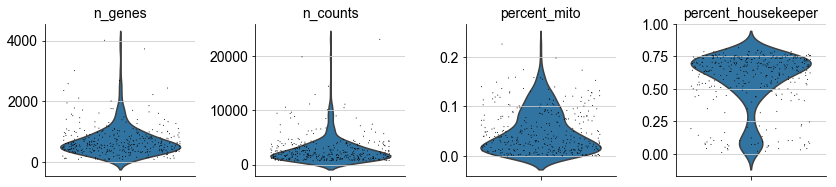

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Library


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


GSM3305367_LinNegCD34NegCD164high.raw_counts.tsv


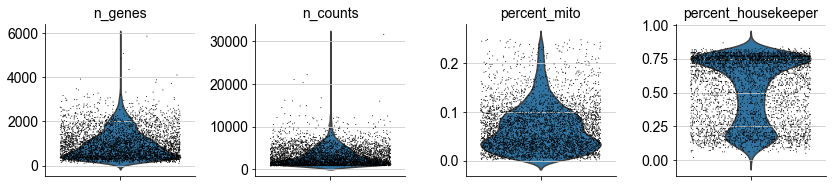

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Library


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


GSM3305368_LinNegCD34lowCD164high.raw_counts.tsv


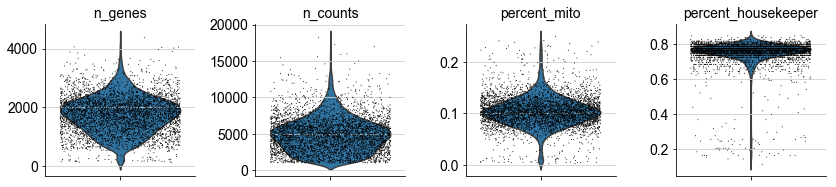

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Library


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


GSM3305366_LinNegCD34PosCD164Pos.raw_counts.tsv


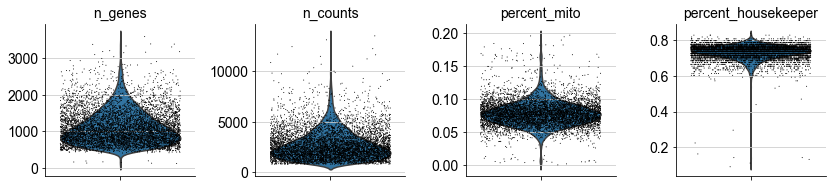

In [6]:
for s in sample_two:
    # run benchmarking
    d = read_raw_counts('/data2/hsher/nature2019_sc/raw_counts/'+s, ignore_lines = 1, transpose = True)
    benchmarking(d, species = 'human')
    
    # see benchmarking result
    print(s)
    sc.pl.violin(d, ['n_genes', 'n_counts', 'percent_mito', 'percent_housekeeper'], jitter=0.4, multi_panel=True)

In [7]:
sample_one+sample_two

['GSM3305359_HSC.raw_counts.tsv',
 'GSM3305360_MPP.raw_counts.tsv',
 'GSM3305363_MEP.raw_counts.tsv',
 'GSM3305364_CMP.raw_counts.tsv',
 'GSM3305365_GMP.raw_counts.tsv',
 'GSM3305362_PreBNK.raw_counts.tsv',
 'GSM3305361_MLP.raw_counts.tsv',
 'GSM3305369_LinNegCD34NegCD164low.raw_counts.tsv',
 'GSM3305367_LinNegCD34NegCD164high.raw_counts.tsv',
 'GSM3305368_LinNegCD34lowCD164high.raw_counts.tsv',
 'GSM3305366_LinNegCD34PosCD164Pos.raw_counts.tsv']

## we will just use their threshold to throw away cells


In [8]:
threshold = [800, 1000, 1000, 800, 2000, 1000, 2000, 800, 800, 800, 800]
# threshold value are from "Methods: cell filtering and data normalization"
# for LinNeg celles they use different threshold for different reps but here the filename cannot tell which rep it is. 
# To retain as much signal as possible I picked the lower threshold

In [9]:
import pandas as pd
thres_df = pd.DataFrame(index = sample_one + sample_two, columns = ['transcript per cell'], data = threshold)

In [10]:
thres_df['annotation'] = ['CMP', 'MEP', 'GMP', 'PreBNK', 'MPP', 'HSC', 'MLP', 'Lin- CD34- CD164low', 'Lin- CD34- CD164high', 'Lin- CD34+ CD164+', 'Lin- CD34low CD164high']

In [14]:
def filter_pellin(sample):
    '''
    input list of samples for experiment
    output combined data matrix
    '''
    d = read_raw_counts('/data2/hsher/nature2019_sc/raw_counts/'+sample)
    
    # put FACs data inside
    d.obs['cluster'] = thres_df.loc[sample, 'annotation']
        
    # filter by transcript per cell
    sc.pp.filter_cells(d, min_counts = thres_df.loc[sample, 'transcript per cell'])
        
    # called benchmarking to calculate 
    benchmarking(d)
        
    # fileter by mitochondrial trancript: dying cell
    d = d[d.obs['percent_mito']<0.25]
    
    # log raw data as raw
    
    
    # normalize, by excludeing frequent gene to avoid distorting data
    #sc.pp.normalize_total(d)
    sc.pp.normalize_total(d, exclude_highly_expressed=True, max_fraction=0.05, inplace=True)
    
        
    # log1p should come before combating batch effect
    sc.pp.log1p(d) 
    #in the paper they did not mention anything about log transformation
        
    # append all batch to list
    return(d)
def concat_data(sample_list):
    processed = list(map(filter_pellin, sample_list))
    concat = processed[0].concatenate(processed[1:len(processed)])
    
    #sc.pp.combat(concat)
    
    return(concat)
def previsualize(concat):
    
    # calling various marker gene from literature
    lineage_calling(concat, species = 'human')
    
    # set the raw data to log form
    d.raw = d
    
    # set highly variable genes
    sc.pp.highly_variable_genes(concat, min_mean=0.0125, max_mean=3, min_disp=0.5)

    # see if batch effect correction changes the result
    # principle component analysis
    sc.tl.pca(concat, svd_solver='arpack')

    # compute neibors for PC
    sc.pp.neighbors(concat, n_neighbors=4, n_pcs=40) # using paper's k=4
    
    # compute umap
    sc.tl.umap(concat) 
    
    # compute louvain cluster
    sc.tl.louvain(concat)
    sc.tl.draw_graph(concat)
    

    return(concat)
    
        

In [12]:
pellin_cd34 = concat_data(sample_one)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Library
Normalizing counts per cell. The following highly-expressed genes are not considered during normalization factor computation:
['MT-ATP6', 'MT-ND1', 'MT-ND4']
    finished (0:00:00):normalized adata.X


/home/hsher/miniconda3/envs/scanpy/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:285: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Library
Normalizing counts per cell. The following highly-expressed genes are not considered during normalization factor computation:
['MT-ND1', 'MT-ND4']
    finished (0:00:00):normalized adata.X
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Library
Normalizing counts per cell. The following highly-expressed genes are not considered during normalization factor computation:
['MT-ND1', 'MT-ND4']
    finished (0:00:00):normalized adata.X
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Library
Normalizing counts per cell. The following highly-expressed genes are not considered during normalization factor computation:
['MT-ATP6', 'MT-ND1', 'MT-ND4']
    finished (0:00:00):normalized adata.X
--> This might be very slow. Consider passing `cache=True`,

In [15]:
previsualize(pellin_cd34)

/home/hsher/miniconda3/envs/scanpy/lib/python3.6/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:36)


AnnData object with n_obs × n_vars = 5908 × 25464 
    obs: 'Library', 'batch', 'cluster', 'n_counts', 'n_genes', 'percent_housekeeper', 'percent_mito', 'B Cell Lineage', 'Basophil Lineage', 'Dendritic Cell Lineage', 'Eosinophil Lineage', 'Erythrocyte Lineage', 'Macrophage Lineage', 'Megakaryocyte Lineage', 'Multi Potential Progenitor', 'NK Cell Lineage', 'Neutrophil Lineage', 'T Cell Lineage', 'C', 'O1', 'O2', 'O3', 'P1', 'P2', 'P3', 'P4', 'V1', 'V2', 'louvain'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain', 'draw_graph'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa'
    varm: 'PCs'

In [ ]:
sc.pl.draw_graph(pellin_cd34, color=pellin_lineage()['Gene Symbol'].tolist()+['louvain', 'cluster'], use_raw=False)

In [ ]:
sc.pl.draw_graph(pellin_cd34, color=['THY1', 'ITGA4', 'PTPRC', 'CD34', 'CD164', 'CD38', 'CD93'], use_raw=False)
# THY1 - CD90, ITGA4 - CD49, PTPRC - CD45

In [ ]:
# pseudotime analysis
def pseudotime_compute(adata, root_cluster, group = 'louvain'):
    sc.tl.paga(adata)
    sc.pl.paga(adata, layout='rt', root=root_cluster) # paga does not make much sense

    sc.tl.diffmap(adata)
    # assign root node
    adata.uns['iroot'] = np.flatnonzero(adata.obs[group] == str(root_cluster))[0]
    sc.tl.dpt(adata)
pseudotime_compute(pellin_cd34, root_cluster = 0, group = 'louvain')

In [ ]:
def read_hand_anno(file):
    '''
    read hand annotation data!
    '''
    d = pd.read_excel(file, index_col = 0)
    # has to be string
    d.index = d.index.astype(str)
    return(d)
pellin_cd34_anno = read_hand_anno('/home/hsher/c2c_input/pellin_cd34_metadata_1211.xlsx')
pellin_cd34.obs['louvain_anno'] = pellin_cd34.obs['louvain'].map(pellin_cd34_anno['Louvain_annotation'])
sc.pl.draw_graph(pellin_cd34, color = 'louvain_anno', legend_loc='on data', legend_fontsize = 5, size = (10,10), save = 'pellin_cd34.pdf')
sc.pl.draw_graph(pellin_cd34, color = 'louvain', legend_loc='on data', legend_fontsize = 12, size = (10,10), palette = 'Set3')



In [ ]:
pellin_lin = concat_data(sample_two)
previsualize(pellin_lin)

In [ ]:
sc.pl.umap(pellin_lin, color=pellin_lineage()['Gene Symbol'].tolist()+['louvain', 'cluster']+['THY1', 'ITGA4', 'PTPRC', 'CD34', 'CD164', 'CD38', 'CD93'], use_raw=False)

In [ ]:
pseudotime_compute(pellin_lin, root_cluster = 8, group = 'louvain')

In [ ]:
pellin_lin_anno = read_hand_anno('/home/hsher/c2c_input/pellin_lin_metadata_1211.xlsx')
pellin_lin.obs['louvain_anno'] = pellin_lin.obs['louvain'].map(pellin_lin_anno['Louvain_annotation'])
sc.pl.draw_graph(pellin_lin, color = 'louvain_anno', legend_loc='on data', legend_fontsize = 5, size = (10,10), save = 'pellin_lin.pdf')
sc.pl.draw_graph(pellin_lin, color = 'louvain', legend_loc='on data', legend_fontsize = 12, size = (10,10), palette = 'Set3')

In [ ]:
pellin_cd34.write('/home/hsher/processed_single_cell_data/pellin_cd34.h5ad')
pellin_lin.write('/home/hsher/processed_single_cell_data/pellin_lin.h5ad')